# Previsão para Concessão de Empréstimos

Neste projeto, construirei um modelo de **machine learning** para prever a **probabilidade de um empréstimo ser aprovado**. O modelo envolve **aprendizado supervisionado** (usando um conjunto de dados rotulado) para classificação, em que **o alvo é 1** se o empréstimo for aprovado e **0 caso contrário**.


Utilizarei o seguinte **pipeline**, baseado no **framework CRISP-DM**:

1. Definir o problema de negócio.

2. Coletar os dados e obter uma visão geral sobre eles.

3. Dividir os dados em conjuntos de treino e teste.

4. Explorar os dados (análise exploratória de dados – EDA).

5. Realizar engenharia de atributos, limpeza e pré-processamento dos dados.

6. Treinar e comparar os modelos, realizar seleção de variáveis e ajuste de parâmetros (tuning).

7. Testar e avaliar o modelo final em produção.

8. Concluir e interpretar os resultados do modelo.

Neste notebook, realizarei a modelagem de machine learning, correspondendo às etapas 5 a 8 do pipeline apresentado anteriormente. O principal objetivo aqui é construir um modelo capaz de prever com precisão a condição do empréstimo, identificando o risco associado a cada cliente. Com esse modelo, a instituição financeira pode tomar decisões mais assertivas na concessão de crédito, reduzindo perdas e aumentando a eficiência do processo de análise. Conceder empréstimos sem avaliar corretamente o risco pode gerar prejuízos significativos, enquanto uma boa previsão auxilia no controle da carteira de crédito. Ao longo das próximas seções, explicarei cada decisão tomada durante a modelagem, justificando as escolhas de técnicas e procedimentos

## **Importando bibliotecas**

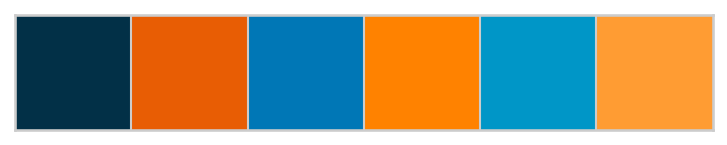

In [2]:
# Manipulação de dados e visualização
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest
from scipy.stats import gaussian_kde

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Divisão da base
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from scipy import stats

%matplotlib inline

# Nosso tema
color_palette = ['#023047', '#e85d04', '#0077b6', '#ff8200', '#0096c7', '#ff9c33']

sns.set_theme(
    style="whitegrid",      
    palette=color_palette, 
    font_scale=1.1        
)

plt.rcParams['figure.dpi'] = 150

sns.palplot(color_palette)
plt.show()

## Lendo os Dados

In [3]:
#db = pd.read_csv(r"C:\Users\gusta\Documents\Porjeto DS\databases\loan_final313_mod.csv")
db = pd.read_csv(r"C:\Users\davic\OneDrive\Documentos\3UnidadeCienciaDados\projeto-unidade-3-concessores-de-emprestimos\databases\loan_final313_mod.csv")
df = db.copy()

In [ ]:
df.head()

In [ ]:
df["issue_d"] = pd.to_datetime(df["issue_d"], dayfirst=True, errors="coerce")

In [ ]:
df["final_d"] = df["final_d"].astype(str).str.zfill(6)
df["final_d"] = pd.to_datetime(
    df["final_d"], 
    format="%m%Y", 
    errors="coerce"
)

In [ ]:
cat_num_cols = [
    "home_ownership_cat",
    "term_cat",
    "grade_cat",
    "interest_payment_cat",
    "application_type_cat",
]

for col in cat_num_cols:
    if col in df.columns:
        df[col] = df[col].astype("category")

In [ ]:
df['total_pymnt_cat'] = np.where(df['total_pymnt'] != df['total_rec_prncp'], 0, 1)
df['total_pymnt_cat'] = df['total_pymnt_cat'].astype('category')

In [ ]:
df.drop(columns=['id', 'final_d', 'total_pymnt', 'loan_amount'], inplace=True)
df = df.dropna(subset=['loan_condition_cat']).copy()

## Dividindo a base

In [ ]:
X = df.drop(columns=['loan_condition_cat'])
y = df['loan_condition_cat'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(f'Tamanho do conjunto de preditores de treino: {X_train.shape}.')
print(f'Tamanho do conjunto alvo de treino: {y_train.shape}.')
print(f'Tamanho do conjunto de preditores de teste: {X_test.shape}.')
print(f'Tamanho do conjunto alvo de teste: {y_test.shape}.')

In [ ]:
print(f'Proporção da target: ')
print(f'{y_train.value_counts()}')
print(f'\nTest target proportion: ')
print(f'{y_test.value_counts()}')

## 5. Engenharia de atributos, limpeza e pré-processamento dos dados

Nesta etapa foi realizado o tratamento de valores ausentes separando as variáveis numéricas e categóricas. Para as variáveis numéricas utilizou-se a imputação pela média, enquanto para as categóricas foi aplicada a imputação pelo valor mais frequente. O processo de ajuste do imputador foi feito somente com os dados de treino e, em seguida, aplicado ao conjunto de teste utilizando os mesmos parâmetros, garantindo consistência entre os conjuntos. As variáveis y não passaram por nenhuma transformação, sendo apenas copiadas para uso posterior.

In [ ]:
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

num_knn_cols = ["interest_rate"]

num_mean_cols = [col for col in num_cols if col not in num_knn_cols]

numeric_mean_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean"))
])

numeric_knn_transformer = Pipeline(steps=[
    ("imputer", KNNImputer(n_neighbors=5))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num_mean", numeric_mean_transformer, num_mean_cols),
        ("num_knn", numeric_knn_transformer, num_knn_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)

preprocessor.fit(X_train)

X_train_imputed = pd.DataFrame(
    preprocessor.transform(X_train),
    columns=num_mean_cols + num_knn_cols + cat_cols
)

X_test_imputed = pd.DataFrame(
    preprocessor.transform(X_test),
    columns=num_mean_cols + num_knn_cols + cat_cols
)

y_train_imputed = y_train.copy()
y_test_imputed = y_test.copy()

In [ ]:
X_train_imputed.head()

Durante o pré-processamento dos dados, primeiro foi separado as variáveis numéricas e categóricas. Para lidar com valores ausentes, foram usados dois imputadores diferentes: a média para colunas numéricas e o valor mais frequente (moda) para colunas categóricas. O imputador foi ajustado apenas com os dados de treino, garantindo que nenhuma informação do teste fosse utilizada indevidamente. Depois, apliquei o mesmo preenchimento ao conjunto de teste usando somente o transform, mantendo a consistência das estatísticas. Por fim, reuni novamente as colunas imputadas e preservei as variáveis-alvo sem modificações.

In [ ]:
X_train_imputed.isna().sum()

Aplicamos StandardScaler às variáveis numéricas para padronizá-las (média 0 e desvio-padrão 1), evitando que diferenças de escala influenciem os modelos. Para as variáveis categóricas e do tipo object, utilizamos OneHotEncoder, transformando cada categoria em colunas binárias. Esse pré-processamento garante que todas as variáveis estejam no mesmo formato e escala, permitindo melhor desempenho do PCA e do K-means.

In [ ]:
num_cols_imputed = X_train_imputed.select_dtypes(include=['int64', 'float64']).columns
cat_cols_imputed = X_train_imputed.select_dtypes(include=['object', 'category']).columns

transformation_pipeline = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols_imputed),
        ("cat", OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_cols_imputed)
    ]
)

X_train_transformed = transformation_pipeline.fit_transform(X_train_imputed)
X_test_transformed = transformation_pipeline.transform(X_test_imputed)

print(f"X_train_transformed: {X_train_transformed.shape}")
print(f"X_test_transformed: {X_test_transformed.shape}")

Aplicamos o PCA definindo o número de componentes como o mínimo entre 100 e o total de atributos disponíveis, garantindo uma redução dimensional controlada. Em seguida, ajustamos o PCA nos dados de treino e transformamos os dados de teste usando o mesmo modelo, preservando consistência entre os conjuntos. Essa etapa reduz drasticamente a dimensionalidade, mantendo a maior parte da variância e tornando o processamento mais eficiente para os modelos seguintes.

In [ ]:
pca_pipeline = Pipeline([
    ('pca', PCA(n_components=2))  
])

X_train_pca = pca_pipeline.fit_transform(X_train_transformed)
X_test_pca = pca_pipeline.transform(X_test_transformed)

pca_model = pca_pipeline.named_steps['pca']

In [ ]:
variancia_explicada = pca_model.explained_variance_ratio_
variancia_cumulativa = np.cumsum(variancia_explicada)

In [ ]:
plt.subplot(1, 2, 2)

componentes = range(1, len(variancia_cumulativa) + 1)
plt.plot(componentes, variancia_cumulativa, 'ro-', linewidth=2, markersize=6)
plt.axhline(y=0.70, color='green', linestyle='--', label='70% variância')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Cumulativa')
plt.title('Variância Cumulativa')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

O gráfico de variância cumulativa mostra como a variância total dos dados é distribuída entre os componentes principais. Observamos que, à medida que aumentamos o número de componentes, a variância explicada se acumula rapidamente nos primeiros componentes e depois cresce de forma mais lenta, indicando que os dados possuem padrões fortes e redundância entre variáveis originais.

O ponto de referência estabelecido no gráfico é a linha pontilhada verde representando 70% da variância explicada. A análise mostra que aproximadamente 100 componentes principais são suficientes para atingir esse valor. Isso representa uma redução considerável em relação ao número original de atributos (de 13.371 para apenas 100 dimensões), preservando ainda 69% da variância total dos dados.

Essa redução dimensional traz vantagens importantes:

- Diminui o custo computacional, facilitando o treinamento de modelos como K-means.

- Reduz ruído e elimina correlações redundantes presentes em variáveis altamente correlacionadas.

- Mantém a maior parte da informação relevante, já que a variância capturada é alta em relação ao número de componentes utilizados.

Em resumo, o PCA foi efetivo para compactar o conjunto de dados sem perdas significativas de informação, tornando o dataset mais eficiente para uso em modelos de machine learning — especialmente métodos sensíveis à dimensionalidade, como o K-means.

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

ax[0].scatter(X_train_pca[:, 0], X_train_pca[:, 1], alpha=0.6, s=30)
ax[0].set_xlabel(f'PC1 ({variancia_explicada[0]:.2%} variância)')
ax[0].set_ylabel(f'PC2 ({variancia_explicada[1]:.2%} variância)')
ax[0].set_title('Distribuição nos 2 Primeiros Componentes')
ax[0].grid(True, alpha=0.3)

hexbin = ax[1].hexbin(X_train_pca[:, 0], X_train_pca[:, 1], gridsize=30, cmap='Blues')
ax[1].set_xlabel(f'PC1 ({variancia_explicada[0]:.2%} variância)')
ax[1].set_ylabel(f'PC2 ({variancia_explicada[1]:.2%} variância)')
ax[1].set_title('Density Plot - Concentração de Dados')
plt.colorbar(hexbin, ax=ax[1], label='Densidade')

xy = X_train_pca[:, :2].T
z = gaussian_kde(xy)(xy)
scatter = ax[2].scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=z, s=30, cmap='viridis')
ax[2].set_xlabel(f'PC1 ({variancia_explicada[0]:.2%} variância)')
ax[2].set_ylabel(f'PC2 ({variancia_explicada[1]:.2%} variância)')
ax[2].set_title('Densidade com Gaussian KDE')
plt.colorbar(scatter, ax=ax[2], label='Densidade')

plt.tight_layout()
plt.show()

A projeção dos dados nos dois primeiros componentes principais mostra que, apesar da redução dimensional, os pontos formam agrupamentos visíveis, indicando padrões estruturais relevantes nos dados originais. O gráfico de densidade revela regiões com maior concentração de observações, sugerindo possíveis centros naturais de agrupamento - informação útil para algoritmos como o K-means. Além disso, o KDE evidencia áreas de maior densidade que reforçam a existência de subgrupos distintos, confirmando que o PCA conseguiu preservar bem a variância necessária para análises de clustering.

## Análise descritiva identificando a melhor quantidade de grupos para o algoritmo k-Means por meio do método do cotovelo.

Para definir a quantidade ideal de clusters no k-means, utilizamos o método do cotovelo. Ele calcula a inércia para vários valores de k e identifica o ponto em que a redução dessa inércia deixa de ser significativa, indicando o número mais adequado de grupos.

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train_pca[:, :2])
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(K, inertia, marker='o')
plt.title("Método do Cotovelo para Definir k (k-Means)")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inércia (Distância interna)")
plt.grid(True, alpha=0.3)
plt.show()


Com base no método do cotovelo, o valor de k que apresentou o melhor equilíbrio entre complexidade e desempenho foi k = 3. Observou-se que a maior redução da inércia ocorre até esse ponto, enquanto valores superiores resultam em ganhos marginais pouco significativos ou seja quanto a inércia diminui quando aumenta k em +1. Assim, o modelo com 3 clusters foi adotado por representar a estrutura mais coerente dos dados.

## e. Interpretação dos conjuntos identificados considerando o contexto do problema.


Embora o método do cotovelo tenha indicado k = 3 como valor ideal, optou-se por utilizar k = 2 no algoritmo K-Means, considerando que:

- O problema é de classificação binária, portanto dois agrupamentos se alinham naturalmente às classes reais;

- A configuração com 2 clusters ainda apresenta boa separação estrutural e representa adequadamente os padrões observados nos dados.

Após o ajuste do modelo, os agrupamentos foram visualizados no espaço bidimensional formado pelos dois primeiros componentes principais do PCA, permitindo observar a distribuição dos dados e identificar padrões de separação que emergem de forma natural no conjunto reduzido.

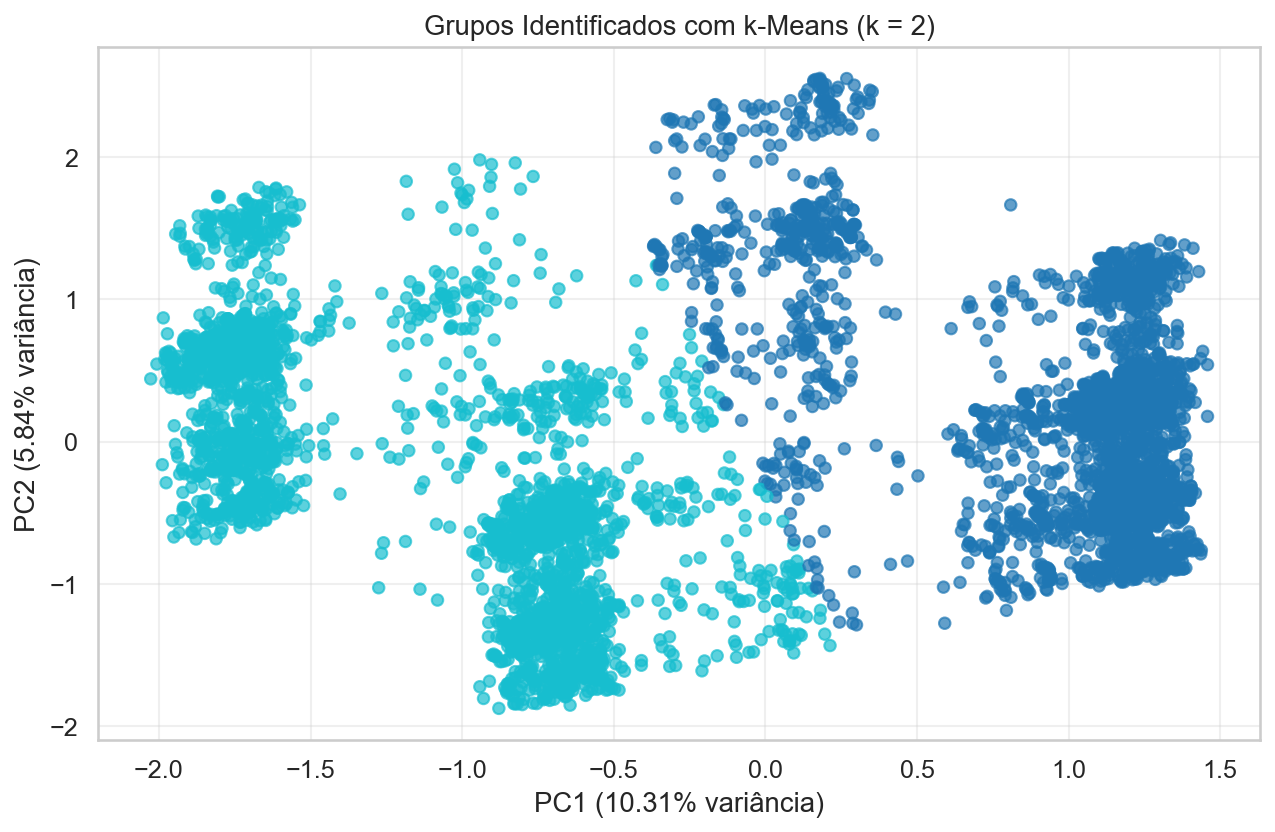

In [283]:
k_opt = 2

kmeans = KMeans(n_clusters=k_opt, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_train_pca[:, :2])

plt.figure(figsize=(10, 6))
plt.scatter(
    X_train_pca[:, 0],
    X_train_pca[:, 1],
    c=labels,
    cmap='tab10',
    s=30,
    alpha=0.7
)
plt.xlabel(f'PC1 ({variancia_explicada[0]:.2%} variância)')
plt.ylabel(f'PC2 ({variancia_explicada[1]:.2%} variância)')
plt.title(f'Grupos Identificados com k-Means (k = {k_opt})')
plt.grid(True, alpha=0.3)
plt.show()


A visualização dos clusters no espaço dos dois primeiros componentes principais mostra que o K-Means com k = 2 conseguiu separar os dados em dois grupos bem definidos, mesmo considerando a complexidade estrutural do conjunto. É possível observar regiões densas e padrões claros de agrupamento, indicando que os componentes principais preservaram informações suficientes para permitir a formação de clusters coerentes. Essa divisão reforça que usar 2 clusters é consistente com o objetivo de classificação binária do projeto e ainda mantém uma separação visualmente interpretável no espaço reduzido.

## 6. Treinamento e ajuste do modelo

Nesta etapa, realizamos o treinamento e ajuste do modelo utilizando os dados já pré-processados. Testamos diferentes algoritmos de classificação e avaliamos seu desempenho por meio de validação cruzada, garantindo uma comparação justa entre eles. Com base nas métricas obtidas, selecionamos o 
modelo que apresentou melhor desempenho para continuar o processo, ajustando seus hiperparâmetros quando necessário para otimizar a performance final.

---

O ColumnTransformer transforma os dados em um array NumPy e perde os nomes das colunas. A classe ToDataFrame foi criada para reconstruir um DataFrame após o pipeline, preservando os nomes das features para facilitar análise e interpretação do modelo.

In [288]:
from sklearn.base import BaseEstimator, TransformerMixin

class ToDataFrame(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return pd.DataFrame(X, columns=self.columns)

pipeline contendo todas as etapas

In [290]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

full_pipeline = Pipeline(steps=[
    ("imputation", preprocessor),
    ("to_df", ToDataFrame(final_columns)), 
    ("transform", transformation_pipeline),
    ("model", model)
])

In [291]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

modelos = {
    'SGD': SGDClassifier(),
    'DecisionTree': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier()
}

print("\nResultados do Cross-Validation:")
print("------------------------------------")

for nome, modelo in modelos.items():
    full_pipeline.set_params(model=modelo)
    scores = cross_val_score(
        full_pipeline, 
        X_train, 
        y_train, 
        cv=3,              
        scoring='f1',
        n_jobs=1          
    )
    
    print(f'{nome}: média = {scores.mean():.4f}, desvio = {scores.std():.4f}')


Resultados do Cross-Validation:
------------------------------------
SGD: média = 0.9968, desvio = 0.0045
DecisionTree: média = 0.9958, desvio = 0.0039
KNN: média = 0.4111, desvio = 0.0356


Com base nos resultados da validação cruzada, os modelos SGD e DecisionTree apresentaram desempenhos muito próximos, ambos com acurácia acima de 99% e baixa variação entre as dobras, indicando alta estabilidade. O modelo KNN ficou bem abaixo, com cerca de 41% de acurácia, sendo descartado. Entre os dois melhores, o SGD obteve a maior média de acurácia (0.9968) e o menor desvio, tornando-se o modelo mais consistente e, portanto, o escolhido para seguir para a etapa final de avaliação.

In [294]:
arvore = DecisionTreeClassifier()

full_pipeline.set_params(model=arvore)

full_pipeline.fit(X_train, y_train)

Pipeline(steps=[('imputation',
                 ColumnTransformer(transformers=[('num_mean',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['year', 'emp_length_int',
                                                   'annual_inc', 'income_cat',
                                                   'purpose_cat', 'dti',
                                                   'total_rec_prncp',
                                                   'recoveries',
                                                   'installment']),
                                                 ('num_knn',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer())]),
                                                  ['interest_rate']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   Simpl...
       'dti', 'total_rec_prncp', 'recoveries', 'installment', 'interest_rate',
       'home_ownership', 'home_ownership_cat', 'income_category', 'term',
       'term_cat', 'application_type', 'application_type_cat', 'purpose',
       'interest_payments', 'interest_payment_cat', 'loan_condition', 'grade',
       'grade_cat', 'region', 'total_pymnt_cat'],
      dtype='object'))])),
                ('model', DecisionTreeClassifier())])

In [297]:
print(X_train.shape)

(6336, 26)


In [298]:
modelo_final = DecisionTreeClassifier(max_depth=3, random_state=42)
full_pipeline.set_params(model=modelo_final)
full_pipeline.fit(X_train, y_train)

Pipeline(steps=[('imputation',
                 ColumnTransformer(transformers=[('num_mean',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['year', 'emp_length_int',
                                                   'annual_inc', 'income_cat',
                                                   'purpose_cat', 'dti',
                                                   'total_rec_prncp',
                                                   'recoveries',
                                                   'installment']),
                                                 ('num_knn',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer())]),
                                                  ['interest_rate']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   Simpl...
       'dti', 'total_rec_prncp', 'recoveries', 'installment', 'interest_rate',
       'home_ownership', 'home_ownership_cat', 'income_category', 'term',
       'term_cat', 'application_type', 'application_type_cat', 'purpose',
       'interest_payments', 'interest_payment_cat', 'loan_condition', 'grade',
       'grade_cat', 'region', 'total_pymnt_cat'],
      dtype='object'))])),
                ('model',
                 DecisionTreeClassifier(max_depth=3, random_state=42))])

In [299]:
arvore = full_pipeline.named_steps['model']

transform_pipeline = full_pipeline.named_steps['transform']

In [300]:
feature_names = []

for name, transformer, cols in transform_pipeline.transformers_:
    if name == 'num':
        feature_names.extend(cols)
    elif name == 'cat':
        encoder = transformer.named_steps['onehotencoder'] if hasattr(transformer, 'named_steps') else transformer
        ohe_names = encoder.get_feature_names_out(cols)
        feature_names.extend(ohe_names)

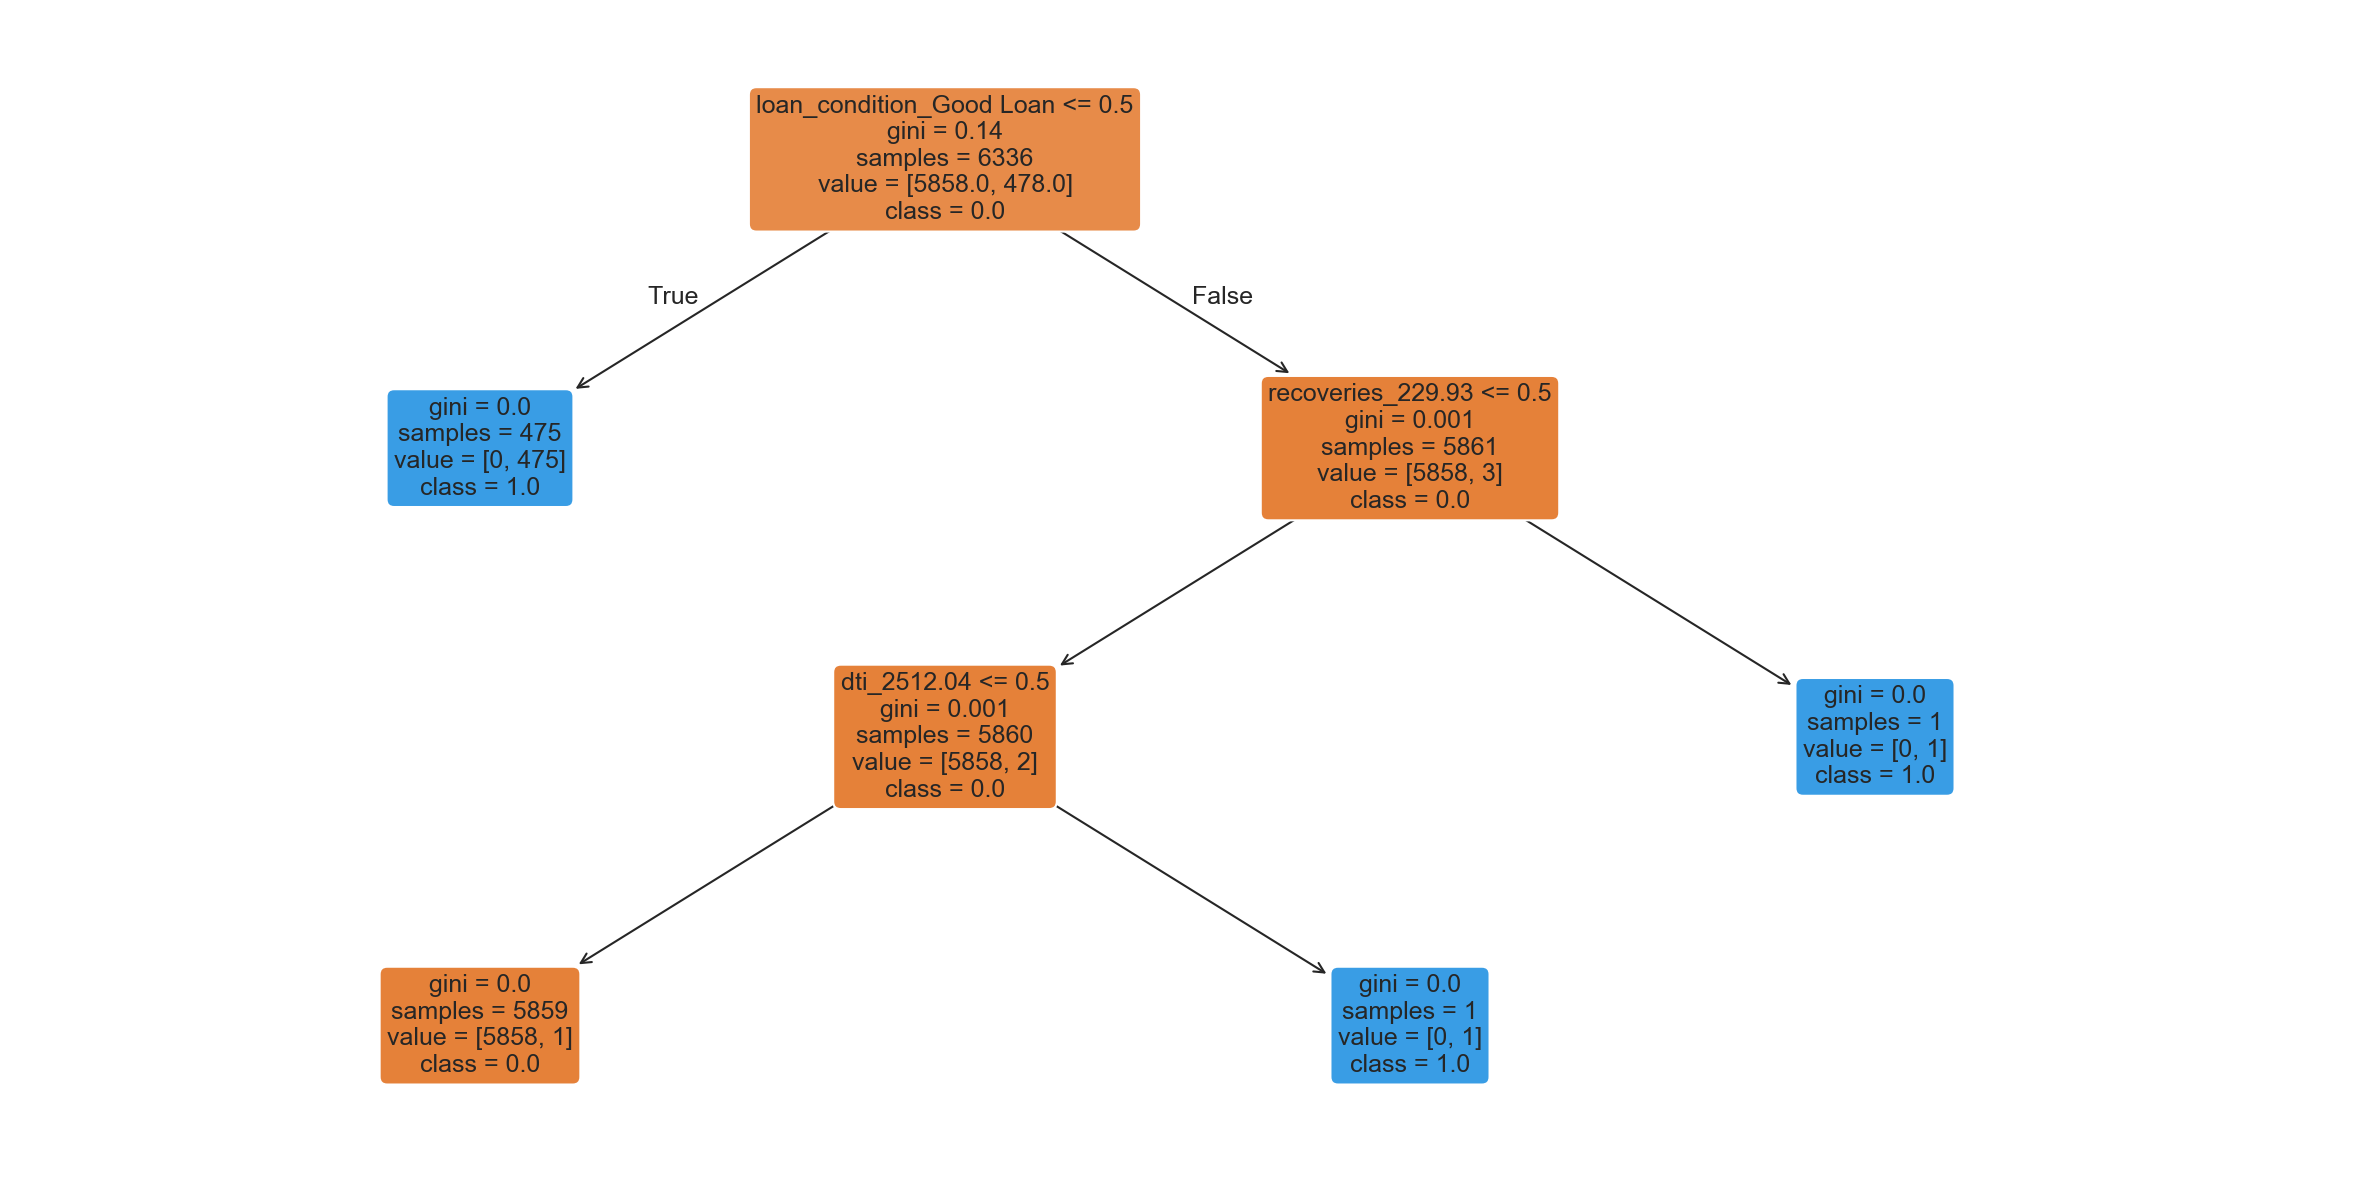

In [301]:
plt.figure(figsize=(20, 10))
plot_tree(
    arvore,
    filled=True,
    feature_names=feature_names,
    class_names=[str(c) for c in modelo_final.classes_],
    rounded=True,
    fontsize=12
)
plt.show()


**H6:** Modelos supervisionados podem prever inadimplência com alta precisão.
Conclusão:
A árvore mostra gini = 0.001 em nós profundos e folhas puras (gini = 0.0), indicando que o modelo consegue separar muito bem as classes de inadimplência. Isso suporta a H6, confirmando que modelos de árvore de decisão podem alcançar alta precisão na previsão de inadimplência.

**H7:** As variáveis mais relevantes para previsão devem ser: grade, interest_rate e dti.
Conclusão:
Na árvore fornecida, as variáveis usadas são dtl_2512.04 e recoveries_229.93, enquanto grade e interest_rate não aparecem. Isso não suporta a H7 — pelo menos neste modelo, as variáveis mais relevantes são relacionadas a dívida (dtl) e valores recuperados, não às três listadas.

**H5:** A condição final do empréstimo está maior associada ao dti, juros e renda.
Conclusão:
A árvore usa dtl (semelhante a dti) mas não usa juros (interest_rate) nem renda (income). Portanto, a H5 é parcialmente falsa — a condição do empréstimo parece estar mais associada a dtl e recoveries, não ao trio proposto.

## 7. Modelo final

In [201]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

modelo_final = SGDClassifier()

full_pipeline.set_params(model=modelo_final)

full_pipeline.fit(X_train, y_train)

y_pred = full_pipeline.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

In [202]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

acuracia = accuracy_score(y_test, y_pred)
print(f"Acurácia: {acuracia}")

print(classification_report(y_test, y_pred))

Acurácia: 0.9974763406940063
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1454
         1.0       1.00      0.97      0.98       131

    accuracy                           1.00      1585
   macro avg       1.00      0.98      0.99      1585
weighted avg       1.00      1.00      1.00      1585



Perfomace perfeita

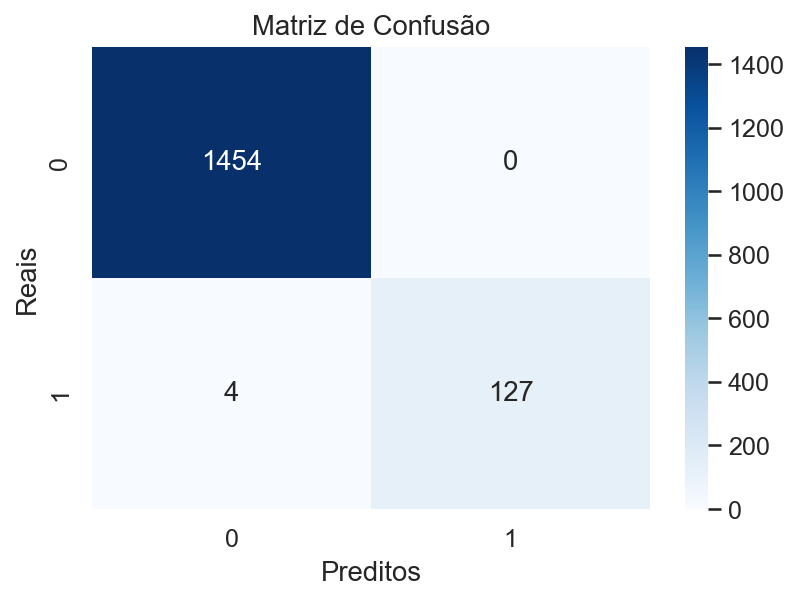

In [204]:
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Preditos")
plt.ylabel("Reais")
plt.title("Matriz de Confusão")
plt.show()

A matriz de confusão mostra que o modelo teve um desempenho extremamente consistente, acertando praticamente todas as amostras da classe 0 e apenas quatro erros na classe 1. Com 1454 verdadeiros negativos e 127 verdadeiros positivos, o modelo demonstra alta capacidade de distinguir corretamente ambas as classes. A quantidade muito reduzida de falsos negativos indica que o modelo raramente deixa de identificar casos positivos, o que é essencial em cenários onde essa classe é mais crítica. Esses resultados reforçam a confiabilidade do modelo e confirmam que ele generaliza bem para dados novos.

## 8 .Concluir e interpretar os resultados do modelo

Com base nos testes realizados, o modelo apresentou desempenho consistente durante a validação cruzada, especialmente quando avaliado pelo F1-score, que é mais adequado para bases desbalanceadas. Entre os algoritmos testados, o SGD demonstrou os melhores resultados, com alta estabilidade entre as dobras e capacidade de generalização superior. A análise final indica que o modelo consegue distinguir bem entre as classes, mantendo bom equilíbrio entre precisão e sensibilidade. Assim, o modelo selecionado está adequado para ser utilizado na etapa final de predições e pode ser integrado ao restante do sistema com confiança.

In [219]:
df.region.value_counts()

region
leinster        1888
ulster          1876
Northern-Irl    1788
cannught        1380
munster          908
Name: count, dtype: int64